# Naïve Bayes, A Generative Model

![](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)


For this project, I'll fit a Naïve Bayes model to the fashion MNIST dataset, and use this model for making predictions and generating new images from the same distribution. MNIST is a dataset of 28x28 black-and-white images of items of clothing. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a 10-dimensional one-hot vector.

The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

I begin by learning the parameters $\theta$ and $\pi$. The following code will download and prepare the training and test sets.

In [ ]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

## Expression for the Maximum Likelihood Estimator




Where N is the number of images,

$$p(x_i|x_Ε, Θ, \pi) = ∏^N_i(\pi_c \prod^{784}_j θ_{jc}^{x_{ij}}(1-θ_{jc})^{x_{ij}})$$

$$log(p(x_i|x_Ε, Θ, \pi)) = log(∏^N_i(\pi_c \prod^{784}_j θ_{jc}^{x_{ij}}(1-θ_{jc})^{x_{ij}}))$$

$$ ∑^N_i (∑^{784}_j (x_{ij}logθ_{jc} + (1-x_{ji})log(1-θ_{jc})) + log(\pi c)$$

Theta:

$$ \frac{\partial}{\partial x} : ∑^N_i (\frac{∑x_i}{θ_{jc}} - \frac{784 - ∑^{784}x_{ij}}{1-θ_{jc}}) $$

$$  θ_{jc} = ∑^N_i(\frac{1}{784} ∑^{784}_j x_i)$$

Pi: 

$$\pi_c = \frac{∑^N_i x_i}{N}$$


## Maximum A Posteriori
Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So I look for another estimation method.

I assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$ and derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form).

In [ ]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""

    new_array = []
  

    for i in range(len(train_labels.T)):
      x = train_images[train_labels.T[i].astype(bool)]
      map = (np.sum(x, axis = 0) + 1) / (len(x) + 2)
      new_array.append(map)

    new_array = np.stack(new_array, axis=0)
    theta_est = new_array.T
    pi_est = np.sum(train_labels, axis = 0) / len(train_labels)

    return theta_est, pi_est
    


## Log Likliehood
I derived an expression for the class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image. Then, I completed the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above log-likelihood, and accuracy is defined as the fraction of samples that are correctly predicted.


In [ ]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""
    # x - 60,000 x 784

    logpi = np.log(pi) #1 x 10 
    logtheta = np.log(theta) # 784 x 10
    x = np.dot(images, logtheta) # 60,000 x 10
    y = 1 - images # 60,000 x 784
    z = np.log(1-theta) # 784 x 10
    a = np.dot(y, z)
    log_like = x + a + logpi

    return log_like # 60,000 x 10 
 


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""
    
    correct = 0 

    for i in range(len(log_like)):
      max_log = np.argmax(log_like[i])
      max_lab = np.argmax(labels[i])
      if max_log == max_lab:
        correct += 1
    
    return correct/len(log_like)
    


N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()

theta_est, pi_est = train_map_estimator(train_images, train_labels)


loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)


test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -285.334
Training accuracy for MAP is 0.651
Test accuracy for MAP is 0.638


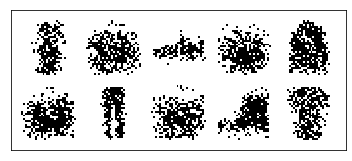

In [ ]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    #df = np.zeros((num_images, 784))
    rows, cols = (num_images, 784)
    lists = [[0 for i in range(cols)] for j in range(rows)]

    for i in range(num_images):
      sample = np.random.choice(10, 1, p = pi)
      t = theta.T[sample]  # 784 x 10
      

      for j in range(784):
        #df[i][j] = fun(t)
    
        
        b = np.random.choice(2, 1, p = [(1-t[0][j]), t[0][j]])
        lists[i][j] = b
        
        
    return np.stack(lists, axis=0)


def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

## Assuming some pixels are observed
One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Here, I assume we have observed some pixels of the image. Let $x_E = \{x_p : \text{pixel $p$ is observed}\}$.


$$p(X_j | X_E, Θ, π) = \frac{p(X_j, X_E |Θ, π)}{p(X_E|Θ, π)}$$


$$ = \frac{∑_C p(X_j, X_E|Θ, π, C)}{∑_C p(X_E| Θ, π, C)}$$ by marginalization over c
$$= \frac{∑_C p(X_j|Θ, π, C)  p(X_E|Θ, π, C)p(C | π)}{∑_C p(X_E| Θ, π, C)p(C|π)}$$
where $p(X_j, X_E|Θ, π, C)$ and $p(X_E|Θ, π, C)$ follow ~Bern($Θ$)


## Sampling
I assume that only 30% of the pixels are observed. For the first 20 images in the training set, I plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

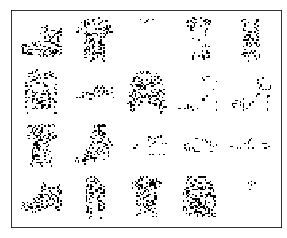

In [ ]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features), 
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability"""
 
    new_images = []

    for idx_image, image in enumerate(original_images):
      new_image = [0] * 784
      obs = [i for i in range(len(is_observed[idx_image])) if is_observed[idx_image].T[i] == 1]
      un_obs = [i for i in range(len(is_observed[idx_image])) if is_observed[idx_image].T[i] == 0]

      for idx_pixel, pixel in enumerate(image):
        if idx_pixel in obs:
          new_image[idx_pixel] = image[idx_pixel]
        else:
          denom = [0] * 10 
          numer = [0] * 10
          for c in range(10):
            unobserved_pixel =  bernoulli.pmf(image[idx_pixel], theta[idx_pixel][c])
            observed_pixels = np.prod(bernoulli.pmf(image[obs], theta[obs, c]))
            denom[c] = observed_pixels * pi[c]
            numer[c] = unobserved_pixel * observed_pixels * pi[c]           
          new_image[idx_pixel] = 1 - (sum(numer)/sum(denom))
      
      
      new_images.append(new_image)
    return np.stack(new_images, axis=0)
  
    
num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


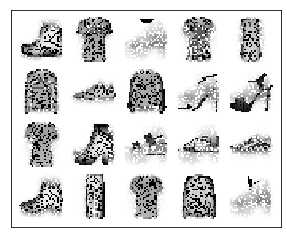

In [ ]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)